# Методы машинного обучения

## Домашнее задание 2

> ###   Выполнил _Жеглов Сергей_

<hr>

**Общая информация**

**Срок сдачи:** 9 Декабря 2018, 23:59 <br/>
**Ссылка для загрузки:** [туть](https://www.dropbox.com/request/xiVtVnOvyGKmYlvYLZry)

<hr>

**Правила оформления:** <br/>
* В названии ноутбука укажите свои имя и фамилию
* Перед сдачей проверьте, что ноутбук исполняется от начала до конца (Kernel - Restart and Run All)
* Перед сдачей проверьте, что ваши результаты репродуцируются (random_states EVERYWHERE)
* Отчищайте ноутбук перед сдачей (Cell - All Output - Clear)
* Не удаляйте ничего из исходного контента (если не требуется обратного)
* Крайне желательно следовать правилам PEP8

Имейте ввиду, что некоторые задания не имеют однозначного ответа. Сопровождайте ДЗ комментариями и илюстрациями в поддержку ваших выводов.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Диагностика заболевания

В этом задании мы поработаем с набором медицинских данных для диагностики диабета. Для загруки данных придется использовать метод `load` из модуля `pickle`.

In [3]:
import pickle

In [4]:
db = pickle.load(open('./data/diabetes.pkl', 'rb'), 
                 encoding='latin1')

In [5]:
y = db['labels']
X = db['data']

Описание признаков следующее:
1. Number of pregnancies
2. Plasma glucose concentration after 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure
4. Triceps skin fold thickness
5. 2-Hour serum insulin
6. Body mass index
7. Diabetes pedigree function
8. Age

Метка класса равна 1 у больного человека

#### Задание 1

Для начала, давайте попробуем пронаблюдать эффект `l1` и `l2` регуляризации
* Загляните в документацию и посмотрите, что делает метод `numpy.logspace`
* Задайте диапазон значений гиперпараметра `C` с помощью `np.logspace(-3, 3, 20)`
* Для каждого значения обучите модель и "запомните" полученные коэффициенты 
* Изобрасите график в котором
    1. По оси Х отложены значения `C` (лучше сделать ее в логарифмическом масштабе - `plt.xscale('log')`)
    2. По оси Y отложены значения коэффициентов модели
    3. Таким образом, для каждого признака у вас должно получится по одной линии
* Не забудте делать предварительную нормализацию признаков в модели
* Как вы объясняете полученные рисунки?

In [6]:
from sklearn import preprocessing

Проведем нормализацию признаков, чтобы в дальнейшем работать с уже нормированными предикторами.

In [7]:
X_scaled = preprocessing.scale(X)

In [8]:
from sklearn.linear_model import Ridge, Lasso

In [9]:
alpha_list = np.logspace(-3, 3, 20)

In [10]:
lasso_coef = []
for i in alpha_list:
    model = Lasso(alpha=i, random_state=2018)
    model.fit(X_scaled, y)
    lasso_coef.append(list(model.coef_))

In [11]:
labels_x = ['Number of pregnancies', 'Plasma glucose concentration after\n 2 hours in an oral glucose tolerance test',
            'Diastolic blood pressure', 'Triceps skin fold thickness', '2-Hour serum insulin', 'Body mass index',
            'Diabetes pedigree function', 'Age']
colors = ['b','g','r','c','m','y','k','w']

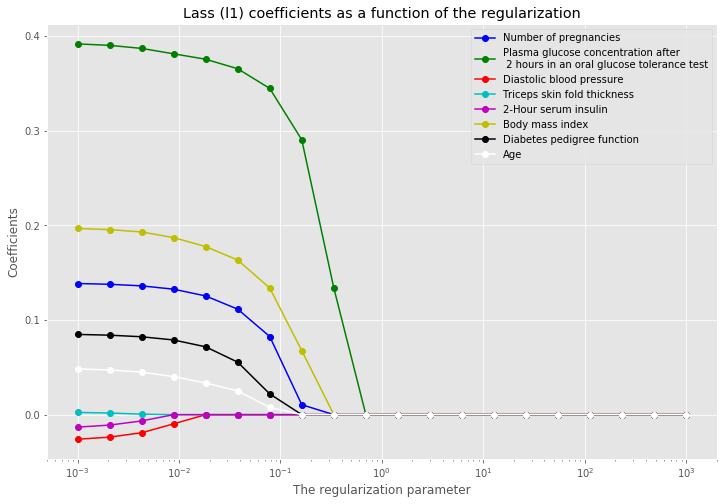

In [12]:
for j in range(len(lasso_coef[0])):
    plt.plot(alpha_list, [i[j] for i in lasso_coef], label = labels_x[j], marker = 'o', c=colors[j])

plt.xscale('log')
plt.xlabel('The regularization parameter')
plt.ylabel('Сoefficients')
plt.title('Lass (l1) coefficients as a function of the regularization')
plt.legend(loc=0)

In [13]:
ridge_coef = []
for i in alpha_list:
    model = Ridge(alpha=i, random_state=2018)
    model.fit(X_scaled, y)
    ridge_coef.append(list(model.coef_))

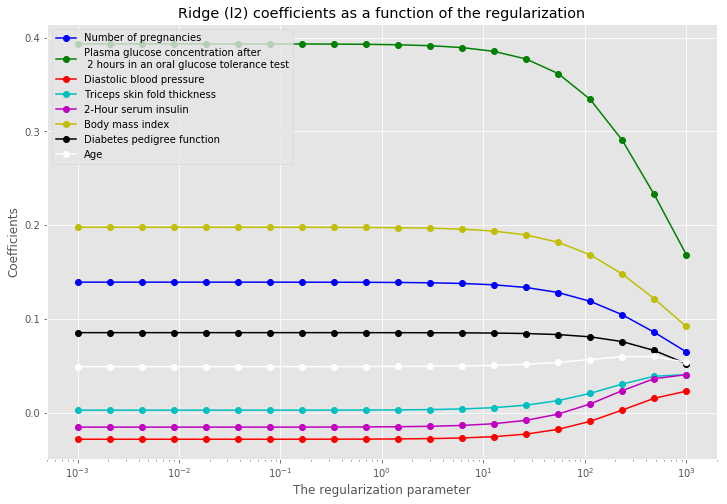

In [14]:
for j in range(len(ridge_coef[0])):
    plt.plot(alpha_list, [i[j] for i in ridge_coef], label = labels_x[j], marker = 'o', c=colors[j])
plt.xscale('log')
plt.xlabel('The regularization parameter')
plt.ylabel('Сoefficients')
plt.title('Ridge (l2) coefficients as a function of the regularization')
plt.legend(loc=2)

**Выводы**

Как мы видим на графиках, при Lasso-регуляризации (l1) с увеличением гиперпараметра коэффициенты модели стремлятся к нулю и, в конце концов, становятся ему равны даже при не самом большом значении гиперпараметра; при Ridge-регуляризации (l2) с увеличением гиперпараметра  коэффициенты модели также уменьшаются по модулю, но нуля не достигают и оказываются на промежутке от 0 до 0.2. Таким образом, Ridge-регуляризация (l2) оказывается предпочтительнее, поскольку не обнуляет коэффициенты, а лишь способствует снижению их значений по модулю, тем самым лучше борется с переобучением модели.

#### Задание 2

С помощью кросс-валидации обучите подберите оптимальный гипепараметр для коэффициента регуляризации `C` в модели логистической регрессии с `l2` регуляризацией
* Используйте `StratifiedKFold` на 7 фолдов
* Не забудте делать предварительную нормализацию признаков в модели

Выведите наилучший ROC-AUC и параметры модели

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

In [16]:
cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=2018)

In [17]:
model_logit_cv = LogisticRegressionCV(penalty='l2', Cs=alpha_list, cv=cv, scoring='roc_auc', random_state=2018)
model_logit_cv.fit(X_scaled, y)

LogisticRegressionCV(Cs=array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=7, random_state=2018, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='warn',
                     n_jobs=None, penalty='l2', random_state=2018, refit=True,
                     scoring='roc_auc', solver='lbfgs', tol=0.0001, verbose=0)

In [18]:
print('Лучший ROC-AUC:',model_logit_cv.scores_[1].mean(axis=0).max())
print('Лучший гиперпараметр С (коэффициент регуляризации):',model_logit_cv.C_[0])

Лучший ROC-AUC: 0.8349077634196239
Лучший гиперпараметр С (коэффициент регуляризации): 1.438449888287663


In [19]:
print('Константа модели:',model_logit_cv.intercept_[0])
print('Коэффициенты модели:')
for i in range(len(labels_x)):
    print(model_logit_cv.coef_[0][i], '*', labels_x[i])

Константа модели: -0.8592837095344756
Коэффициенты модели:
0.4164625436208438 * Number of pregnancies
1.1242113942096659 * Plasma glucose concentration after
 2 hours in an oral glucose tolerance test
-0.10421174930475942 * Diastolic blood pressure
0.031982013090473826 * Triceps skin fold thickness
-0.06184263607326709 * 2-Hour serum insulin
0.6330796080137924 * Body mass index
0.2844525912644322 * Diabetes pedigree function
0.1557597715264862 * Age


#### Задание 3

В медицинских приложения ошибки False Positive и False Negative имеют разную "стоимость"

Если своевременно не обнаружить заболевание, то пациент может сильно пострадать, в то время как при ложном срабатывании, для достоверности можно повторно сдать анализы
Таким образом цена этих ошибок разная. 

Для модели из задания 2
* Мы не будем обучаться и применять модель на том же множестве. Чтобы оценка была несмещенной посмотирте в документации, что делает метод [`model_selection.cross_val_predict`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html) и воспользуйтесь им
* Выведите матрицу перемешивания `sklearn.metrics.confusion_matrix` и FPR и FNR по ней


In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

Воспользуемся лучшей моделью, полученной в результате обучения LogisticRegressionCV, для предсказания классов (необходимо для матрицы перемешивания) и предсказания вероятнностей (необходимо для построения roc-auc). Установим labels = [1, -1], чтобы True Positive соответствовали верно предсказанному количеству заболевших (поскольку метка 1 соответствует заболевшему).

In [21]:
best_logit = LogisticRegression(penalty='l2',C= model_logit_cv.C_[0], random_state=2018, solver='lbfgs')
y_pred_class = cross_val_predict(best_logit, X_scaled, y, cv=cv)
y_pred_proba = cross_val_predict(best_logit, X_scaled, y, cv=cv, method='predict_proba').T[1]

Построим и выведем матрицу перемешивания:

In [22]:
conf_mat = confusion_matrix(y, y_pred_class, labels = [1, -1])
conf_mat

array([[150, 118],
       [ 62, 438]], dtype=int64)

In [23]:
n_pos = conf_mat[0].sum()
n_neg = conf_mat[1].sum()
print('False Negative (ошибочно не обнаружено заболевний):', conf_mat[0][1])
print('False Negative Rate (доля ошибочно не обнаруженных заболевний):', conf_mat[0][1]/n_pos)
print('False Positive (ложное срабатывание):', conf_mat[1][0])
print('False Positive Rate (доля ложных срабатываний):', conf_mat[1][0]/n_neg)

False Negative (ошибочно не обнаружено заболевний): 118
False Negative Rate (доля ошибочно не обнаруженных заболевний): 0.44029850746268656
False Positive (ложное срабатывание): 62
False Positive Rate (доля ложных срабатываний): 0.124


In [24]:
print('N_pos (истинное число заболевших):', n_pos)
print('N_neg (истинное число здоровых):', n_neg)

N_pos (истинное число заболевших): 268
N_neg (истинное число здоровых): 500



#### Задание 4

Чтобы изменить пропорции ошибок 1го и 2го рода вы можете менять порог классификации $a$ в выражении $p(+1| x) = \sigma(w^\top x + w_0) > a$, где $p(+1| x)$ - оценка вероятность объекта $x$ принадлежать классу $+1$, которая дает ваша модель.

Нарисуйте ROC кривую полученного классификатора и точку, соответствующую порогу $a = 0.5$ 

Воспользовавшишь графиком ROC кривой выберите такой порог $a$ что FNR <= $20%$ при том что FPR еще не велико. Процесс подбора и результирующие Accuracy, $a$, FPR и FNR выведите ниже

HINT: `sklearn.metrics.roc_curve`.

In [25]:
from sklearn.metrics import roc_curve, auc

Точка - порог (a), на основе которого были предсказаны классы для матрицы перемешивания и который равен: 0.4979270989281232


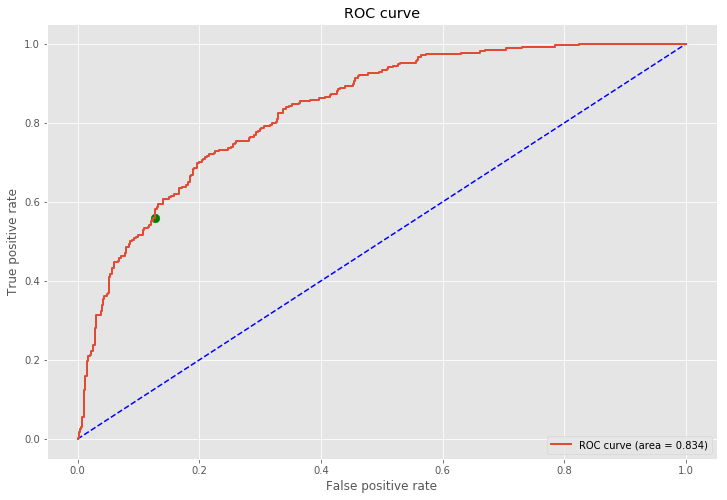

In [26]:
fpr, tpr, thres = roc_curve(y, y_pred_proba, pos_label=1)

plt.plot([0, 1], [0, 1], 'k--', c = 'b')
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

a_thres_index = np.argmin(abs(thres-0.5))
print('Точка - порог (a), на основе которого были предсказаны классы для матрицы перемешивания и который равен:',
      thres[a_thres_index])
plt.scatter(fpr[a_thres_index], tpr[a_thres_index], marker='.', c='g', s=300)

Мы знаем, что  $N_{pos} = TP + FN$ или, иначе говоря, $1 = TPR + FNR$. Как следствие, из двух уравнений: 
\begin{align}
FNR = 1 - TPR \\
FN \leq 0.2 \\
\end{align}
Следует, что 
\begin{align}
1 - TPR \leq 0.2 \\
TPR \geq 0.8 \\
\end{align}
Таким образом, нас интересуют все значения, которые находятся на красной линии от 0.8 до 1 по оси ординат ($TPR$), их также можно отобразить ниже.
Вывдем все возможные значния $TPR$, $FPR$ и порога ($\alpha$) при $TPR \geq 0.8$:

In [27]:
print('Значения TPR при TPR>=0.8:', tpr[np.where(tpr>=0.8)], sep = '\n')
print()
print('Значения FPR при TPR>=0.8:',fpr[np.where(tpr>=0.8)], sep= '\n')
print()
print('Значения a (порога) при TPR>=0.8:',thres[np.where(tpr>=0.8)], sep= '\n')

Значения TPR при TPR>=0.8:
[0.80223881 0.80223881 0.80970149 0.80970149 0.82462687 0.82462687
 0.8358209  0.8358209  0.83955224 0.83955224 0.84328358 0.84328358
 0.84701493 0.84701493 0.85074627 0.85074627 0.85447761 0.85447761
 0.85820896 0.85820896 0.8619403  0.8619403  0.86567164 0.86567164
 0.86940299 0.86940299 0.87313433 0.87313433 0.88059701 0.88059701
 0.88432836 0.88432836 0.8880597  0.8880597  0.89179104 0.89179104
 0.89925373 0.89925373 0.90671642 0.90671642 0.9141791  0.9141791
 0.91791045 0.91791045 0.92164179 0.92164179 0.92537313 0.92537313
 0.92910448 0.92910448 0.93283582 0.93283582 0.93656716 0.93656716
 0.94029851 0.94029851 0.94402985 0.94402985 0.94776119 0.94776119
 0.95149254 0.95149254 0.95522388 0.95522388 0.95895522 0.95895522
 0.96641791 0.96641791 0.97014925 0.97014925 0.9738806  0.9738806
 0.97761194 0.97761194 0.98134328 0.98134328 0.98507463 0.98507463
 0.98880597 0.98880597 0.99253731 0.99253731 0.99626866 0.99626866
 1.         1.        ]

Значения FPR

Остановимся на пороге, при котором TPR достигает максимального значения (иначе говоря, FNR минимального) и FPR не достигает 0.5.

In [28]:
final_index = np.where((tpr>=0.8)&(fpr<0.5))[0][-1]
print('TPR:', tpr[final_index])
tp = int(tpr[final_index]*n_pos)
print('TP (выявлено заболевших):', tp, ' из ', n_pos)
print()
fp = int(fpr[final_index]*n_neg)
print('FPR :',fpr[final_index])
print('FP (здоровые, ошибочно принятые за заболевших):', fp, ' из ', n_neg)
print()
print('FNR :',1-tpr[final_index])
print('FN (не обнурежено заболевших):',n_pos - tp, ' из ', n_pos)
print()
print('а (порог):',thres[final_index])

TPR: 0.9291044776119403
TP (выявлено заболевших): 249  из  268

FPR : 0.496
FP (здоровые, ошибочно принятые за заболевших): 248  из  500

FNR : 0.07089552238805974
FN (не обнурежено заболевших): 19  из  268

а (порог): 0.16808105708257445


Зная, что $TN = N_{neg}-FP$, вычислим $Accuracy$ по формуле:
\begin{align}
Accuracy = \frac{TP+TN}{N_{pos}+N_{neg}} \\
\end{align}

In [29]:
tn = n_neg-fp
print('Accuracy',(tp+tn)/(n_pos+n_neg))

Accuracy 0.65234375


Отметим точку выбранного порога на графике:

Звездочка - выбранный нами порог (a), равный 0.16808105708257445


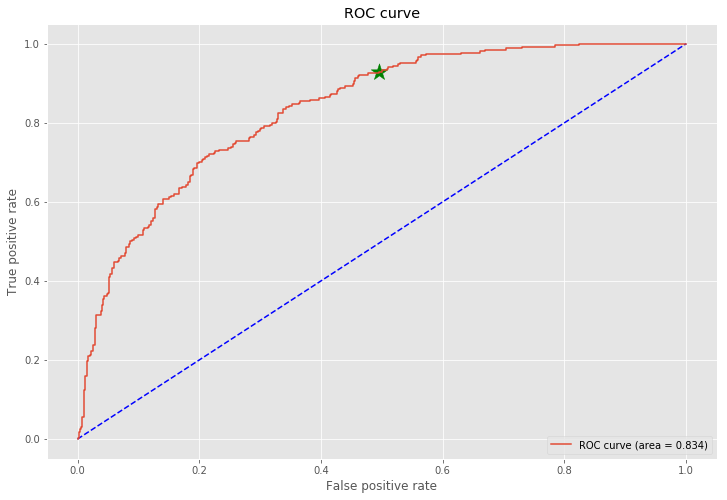

In [30]:
fpr, tpr, thres = roc_curve(y, y_pred_proba, pos_label=1)
plt.plot([0, 1], [0, 1], 'k--', c = 'b')
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

print('Звездочка - выбранный нами порог (a), равный', thres[final_index])
plt.scatter(fpr[final_index], tpr[final_index], marker='*', c='g', s=300)